In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.cluster.hierarchy import cut_tree
from sklearn.cluster import KMeans

In [4]:
df = pd.read_csv("NasdaqReturns.csv")

In [5]:
df.head()

,StockSymbol,Industry,SubIndustry,Ret2000.01,Ret2000.02,Ret2000.03,Ret2000.04,Ret2000.05,Ret2000.06,ret2000.07,...,Ret2009.03,Ret2009.04,Ret2009.05,Ret2009.06,Ret2009.07,Ret2009.08,Ret2009.09,Ret2009.10,Ret2009.11,Ret2009.12
0,AAON,Industrial Goods,General Building Materials,0.080678,0.066250,0.032941,0.183099,0.130334,-0.017642,-0.020517,...,0.185088,0.100565,0.067762,-0.045062,-0.025832,0.060976,-0.039234,-0.101297,0.041804,0.019885
1,AAPL,Consumer Goods,Electronic Equipment,-0.010680,0.102115,0.145496,-0.084428,-0.327300,-0.359266,-0.025321,...,0.192919,0.208858,0.079571,0.043673,0.138606,0.018159,0.103339,0.016995,0.053267,0.041980
2,ABAX,Healthcare,Diagnostic Substances,0.047742,0.035990,0.039702,-0.162353,-0.147427,0.048589,-0.135385,...,0.111541,-0.119907,0.162126,0.161108,0.304581,0.001883,0.014026,-0.141783,-0.024740,0.134043
3,ABCB,Financial,Regional,-0.074040,-0.048170,0.018219,-0.024679,-0.006036,-0.025304,-0.094000,...,-0.024845,0.402570,-0.039816,-0.020155,0.004651,0.007812,0.122449,-0.170423,0.105351,0.062315
4,ABFS,Services,Trucking,-0.031046,-0.212677,0.091476,0.189338,-0.153846,-0.106115,0.355301,...,0.113583,0.227007,0.216357,-0.075114,0.069471,0.112273,-0.052831,-0.127703,-0.047582,0.191981


## (a) Data exploration

In [6]:
# (i) Total no. of companies & no. of companies grouped by industry

num_companies = df['StockSymbol'].nunique()
print(f"Number of companies: {num_companies}")

industry_counts = df.groupby('Industry')['StockSymbol'].nunique().reset_index()
industry_counts.columns = ['Industry', 'Number of Companies']
print("Number of companies in each industry:")
print(industry_counts)

Number of companies: 1158
Number of companies in each industry:
            Industry  Number of Companies
0    Basic Materials                   50
1      Conglomerates                    2
2  Consumer Cyclical                    2
3     Consumer Goods                   80
4          Financial                  338
5         Healthcare                  111
6   Industrial Goods                   65
7           Services                  202
8         Technology                  296
9          Utilities                   12


In [7]:
# (ii) Stocks with ≥10% Increase/Decrease in December 2000

increase_10 = df[df['Ret2000.12'] >= 0.1]['StockSymbol'].count()
decrease_10 = df[df['Ret2000.12'] <= -0.1]['StockSymbol'].count()

print(f"Number of stocks with ≥10% increase in Dec 2000: {increase_10}")
print(f"Number of stocks with ≥10% decrease in Dec 2000: {decrease_10}")

Number of stocks with ≥10% increase in Dec 2000: 309
Number of stocks with ≥10% decrease in Dec 2000: 261


In [11]:
# (iii) Worst-Hit Industries in October 2008

mean_returns_oct2008 = df.groupby('Industry')['Ret2008.10'].mean().sort_values()
print(mean_returns_oct2008)

Industry
Conglomerates       -0.265748
Basic Materials     -0.254674
Industrial Goods    -0.233366
Technology          -0.196299
Services            -0.173833
Healthcare          -0.169440
Consumer Goods      -0.155209
Consumer Cyclical   -0.145705
Utilities           -0.120087
Financial           -0.102884
Name: Ret2008.10, dtype: float64
Industries sorted by average returns in Oct 2008 (worst to best):


## (b) Clustering stocks

In [17]:
returns_columns = [col for col in df.columns if col.startswith('Ret')]
X = df[returns_columns]

(i)  **Why not normalize?**

We do not normalize the data in this analysis because stock returns are already measured in comparable units (percentage), making their scales consistent. Normalization is typically required when the features have different units/ ranges because clustering rely on distance measures, which are sensitive to the scale of the variables. However, in our case, all variables represent percentage returns.

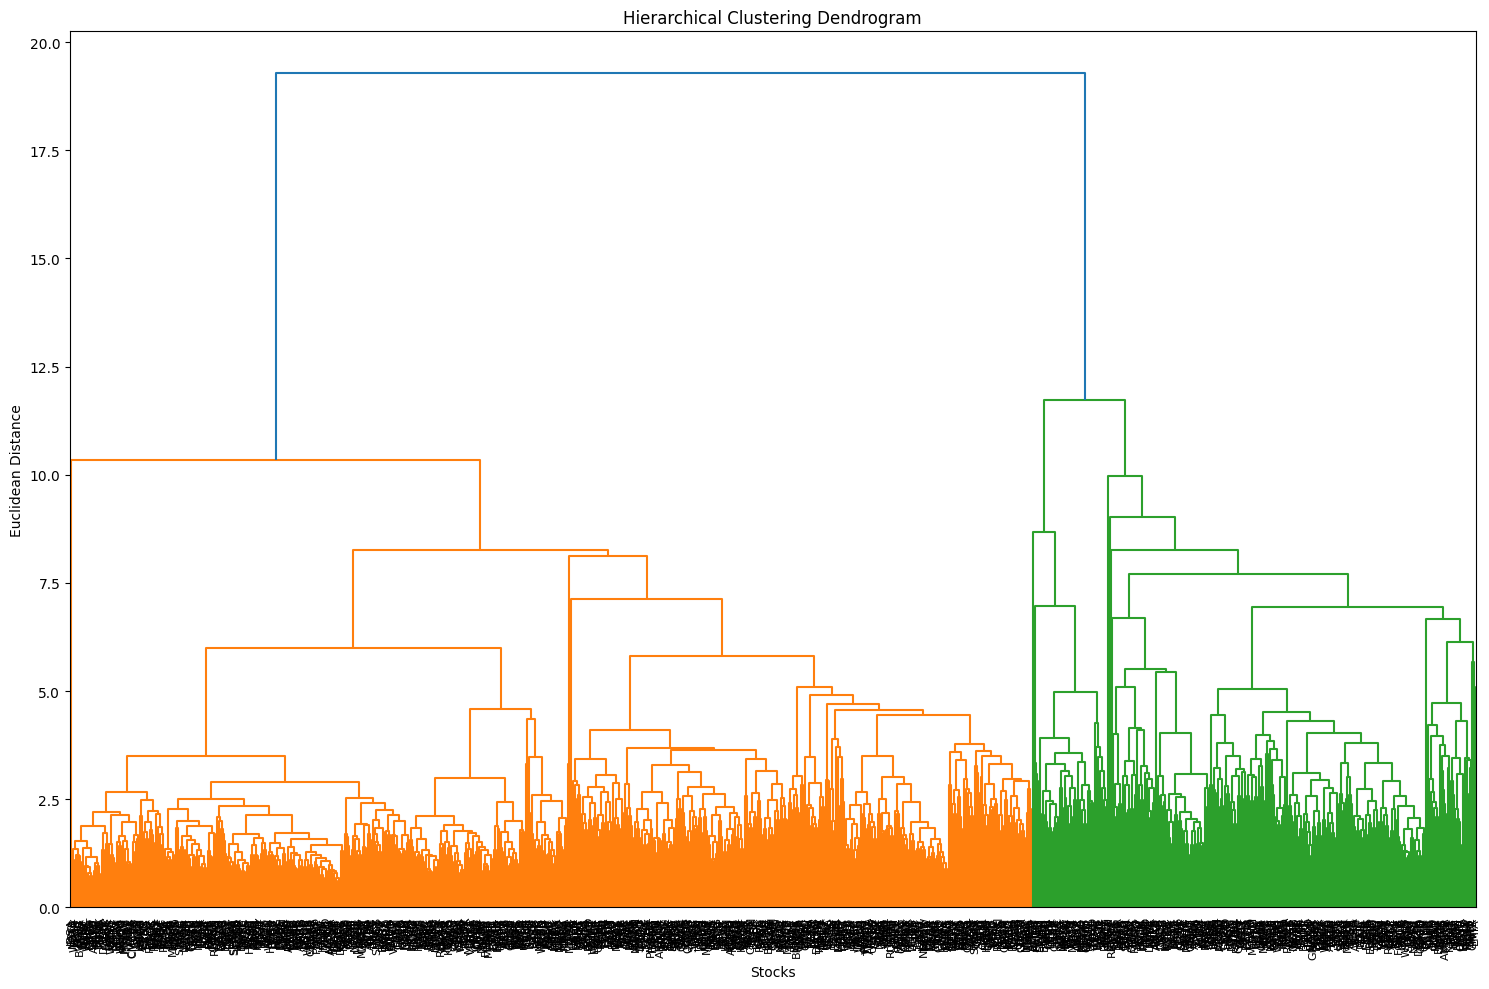

In [18]:
# (ii) Hierarchical clustering

Z = linkage(X, 'ward', metric='euclidean')
plt.figure(figsize=(15, 10))
dendrogram(Z, labels=df['StockSymbol'].values, leaf_rotation=90, leaf_font_size=8)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Stocks")
plt.ylabel("Euclidean Distance")
plt.tight_layout()
plt.show()

(ii)
The distance metric used for point-to-point distances is **Euclidean** distance.
The distance metric for cluster-to-cluster distances is **ward**.

The dendrogram splits into 2 main clusters clearly (orange & green) meaning the stocks in these 2 are significantly different. To diversify portfolio, we would want the clusters to represent distinctly different groups of stocks. Fewer clusters allow us to see broad patterns in stock performance, such as low vs. high returns or stable vs. volatile stocks. This helps in selecting stocks from each cluster for diversification.

Decided to go with **3** clusters, capturing slightly more detailed distinctions than 2 clusters while still maintaining interpretability. (Had tried with 4 clusters but 1 of them only had 1 company, so merged it). 2 clusters would do high v/s low stocks. 3 may now do high-moderate-low performers.

Checked 2000 average return for each cluster to analyze how companies performed during Dotcom Bubble. Also checked average 2000-2002 to include post-recovery effects. Overall, looking to diversify portfolio such that we are prepared for such events in future.

In [64]:
# (iii) Cluster assignment

df.rename(columns={'ret2000.07': 'Ret2000.07'}, inplace=True)

# Adding cluster IDs
X.loc[:, 'cluster_ids_hierarchical'] = cut_tree(Z, n_clusters=3).flatten()
df['cluster_ids_hierarchical'] = X['cluster_ids_hierarchical']

# Average return for 2000
monthly_columns_2000 = ['Ret2000.' + str(i).zfill(2) for i in range(1, 13)]
df['average_return_2000'] = df[monthly_columns_2000].mean(axis=1)

# Average return for 2001 and 2002
monthly_columns_2001 = ['Ret2001.' + str(i).zfill(2) for i in range(1, 13)]
monthly_columns_2002 = ['Ret2002.' + str(i).zfill(2) for i in range(1, 13)]

df['average_return_2001'] = df[monthly_columns_2001].mean(axis=1)
df['average_return_2002'] = df[monthly_columns_2002].mean(axis=1)

# Adding total average return for 2000, 2001, and 2002
df['average_return_2000_2002'] = df[['average_return_2000', 'average_return_2001', 'average_return_2002']].mean(axis=1)

# Analyzing the clusters
clusters_summary = df.groupby('cluster_ids_hierarchical').agg(
    industry_count=('Industry', 'count'),
    average_return=('average_return_2000', 'mean'),  # 2000 average return
    average_return_2000_2002=('average_return_2000_2002', 'mean'),  # Total average return for 2000, 2001, and 2002
    unique_industries=('Industry', 'nunique'),
    unique_sub_industries=('SubIndustry', 'nunique'),
    industries=('Industry', 'unique'),  # Industry names
)

# Resetting index and renaming columns
clusters_summary = clusters_summary.reset_index()
clusters_summary.columns = [
    'Cluster ID Hierarchical', 'No. of Companies', 'Avg. Return (2000)', 'Avg. Return (2000-2002)',
    'Unique Industries', 'Unique Sub-Industries', 'Industries'
]

# Displaying the summary
print(clusters_summary.to_string(index=False))


 Cluster ID Hierarchical  No. of Companies  Avg. Return (2000)  Avg. Return (2000-2002)  Unique Industries  Unique Sub-Industries                                                                                                                                    Industries
                       0               793            0.005302                 0.012543                 10                    145 [Industrial Goods, Healthcare, Financial, Services, Consumer Goods, Basic Materials, Technology, Utilities, Conglomerates, Consumer Cyclical]
                       1               303           -0.021880                 0.000014                  8                     79                                   [Consumer Goods, Healthcare, Technology, Financial, Services, Industrial Goods, Basic Materials, Utilities]
                       2                62            0.090787                 0.020557                  4                     26                                                       

(iii) Description of each cluster

**Cluster 0**:
This cluster consists of the largest group of companies, showing stable, slightly positive returns during both the Dotcom Bubble and the subsequent recovery period (2000-2002). It includes a mix of industries indicating that these companies are diversified and resilient, likely representing well-established, large-cap firms with stable performance.

**Cluster 1**:
Companies in this cluster experienced negative returns in 2000-01, with only modest recovery in 2000-2002. It contains industries like Consumer Goods and Financial, which were hit hard by the Dotcom Bubble and struggled to rebound. This suggests these companies faced more volatility and slower recovery, likely mid-cap firms or those in more cyclical sectors.

**Cluster 2**:
This small cluster includes high-growth companies that performed well during the Dotcom Bubble (2000-01) and continued to show positive returns during 2000-2002. It primarily consists of Technology and Healthcare sectors, indicating that these firms were more aligned with the tech boom and likely represented smaller, growth-oriented companies that thrived in the post-bubble recovery.

In [65]:
# (iv) 2000 - Mar & Feb average return for each cluster

avg_returns_feb_mar_2000 = df.groupby('cluster_ids_hierarchical').agg(
    avg_return_feb_2000=('Ret2000.02', 'mean'),
    avg_return_mar_2000=('Ret2000.03', 'mean')
)

avg_returns_feb_mar_2000 = avg_returns_feb_mar_2000.reset_index()
avg_returns_feb_mar_2000.columns = ['Cluster ID Hierarchical', 'Avg. Return (Feb 2000)', 'Avg. Return (Mar 2000)']

print(avg_returns_feb_mar_2000.to_string(index=False))

 Cluster ID Hierarchical  Avg. Return (Feb 2000)  Avg. Return (Mar 2000)
                       0               -0.002871                0.022439
                       1                0.229079               -0.076308
                       2                1.228149               -0.297683


The variations in the February and March returns for each cluster suggest different reactions to the market conditions during the dot-com bubble period. The negative return in March for most clusters aligns with the overall market correction, while the high return for Cluster 2 in February points to potential overvaluation or high-risk speculative investments that eventually corrected.

In [66]:
# (v) K-means clustering

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)
X.loc[:, 'cluster_ids_kmeans'] = kmeans.predict(X)
print(kmeans.cluster_centers_.shape)

(3, 122)


In [69]:
cluster_comparison = X[['cluster_ids_kmeans', 'cluster_ids_hierarchical']].copy()
cluster_comparison.head()

,cluster_ids_kmeans,cluster_ids_hierarchical
0,1,0
1,1,1
2,1,0
3,1,0
4,1,0


In [70]:
cluster_comparison['match'] = cluster_comparison['cluster_ids_kmeans'] == cluster_comparison['cluster_ids_hierarchical']
print(cluster_comparison['match'].value_counts())

match
False    982
True     176
Name: count, dtype: int64


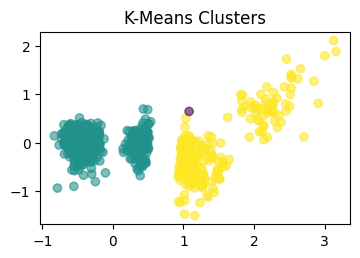

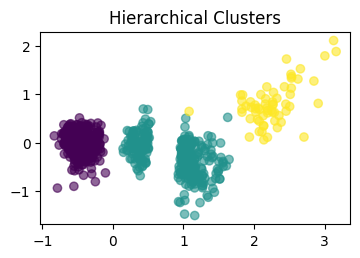

In [76]:
from sklearn.decomposition import PCA

# Dimensionality reduction to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plotting clusters
plt.figure(figsize=(4, 2.5))

# Plotting K-Means clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=X['cluster_ids_kmeans'], cmap='viridis', alpha=0.6)
plt.title("K-Means Clusters")
plt.show()

# Plotting Hierarchical clusters
plt.figure(figsize=(4, 2.5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=X['cluster_ids_hierarchical'], cmap='viridis', alpha=0.6)
plt.title("Hierarchical Clusters")
plt.show()

The discrepancy arises because K-Means creates clusters by minimizing variance around centroids, often resulting in spherical and equally sized clusters. In contrast, Hierarchical Clustering groups data based on pairwise distances, allowing for more flexible and irregular shapes. This leads to different cluster assignments, explaining the mismatch in results. The difference is not too significant, but reflects the inherent nature of each clustering method.

## (c) Selecting diverse portfolio of stocks :-


**Using Hierarchical Clustering**

Select stocks from different clusters to ensure a mix of risk profiles and industries. For example, choose stocks with stable returns from one cluster and high-growth stocks from another. This provides industry and risk diversification.

Hierarchical clustering is good for understanding stock relationships and selecting a diverse set of stocks with varying return profiles and sector exposure.

**Using K-Means Clustering**

Select one stock from each of the 3 K-Means clusters, ensuring you capture different return patterns. Choose stocks with consistent returns, growth potential, and undervalued opportunities.

K-Means is ideal for quick grouping and clear stock selection, providing distinct clusters based on performance for portfolio balance.

**Integrated Approach**
Combine both methods by selecting stocks from each cluster in both hierarchical and K-Means results. This ensures a portfolio with diverse risk-return profiles and industry representation, balancing growth and stability.